In [373]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy
import ray
import pandas as pd
import seaborn as sns

In [345]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 6
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.false_data_types = []
        self.false_data_allocation = []
        self.false_data = {}
        self.false_devices = {}

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            self.false_data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.false_data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.false_devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: devices[2:4],
            1: devices[4:6],
            2: devices[6:8],
            # 3: devices[:bound]
            3: [0]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def false_construct_dictionaries(self):
        for i in self.false_data:
            for j in self.false_data[i]:
                self.false_data[i][j] = 0
        for i in self.false_devices:
            for j in self.false_devices[i]:
                self.false_devices[i][j] = 0
        for device, d_type in zip(self.false_data_allocation, self.false_data_types):
            self.false_data[d_type][device] += 1
            self.false_devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def false_free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.s_capacity
            # if load[i] <= self.min_free_space:
            #     self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        plt.title("Architecture with six stations:")
        plt.axis('off')
        plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def false_compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.false_data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def compute_normalized_latency_dict(self):    # CHANGEEEEEEEEEEEEEE
        total_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }
        max_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }

        for key in total_latency.keys():
            for dev in range(len(self.clusters[key])):
                if self.clusters[key][dev] in self.action_device:
                    for j in self.data[key]:
                        total_latency[key] += self.latencies[self.clusters[key][dev]][j] * self.data[key][j]
                        max_latency[key] += self.data[key][j]
        for i in total_latency.keys():
            total_latency[i] = 1-total_latency[i]/(max_latency[i]*22+1)

        return total_latency

    # def rl_update(self, new_allocation):
    #     self.data_allocation = new_allocation
    #     self.construct_dictionaries()
    #     return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation-10],1)[0] if operation != 13 else self.clusters[operation-10][0] # CHANGEEEEEEEEEEEEEEE
            # device=self.clusters[operation - 10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def round_robin(self):
        allocation_round = []
        capacities = [50,50,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]  # CHANGEEEEEEEEEEEEEEEEEEEEE
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:      # CHANGEEEEEEEEEEEEEEEEEEEEE
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(80 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0          # CHANGEEEEEEEEEEEEEEEEEEEEE
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(122 - len(allocation_greedy)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(122 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

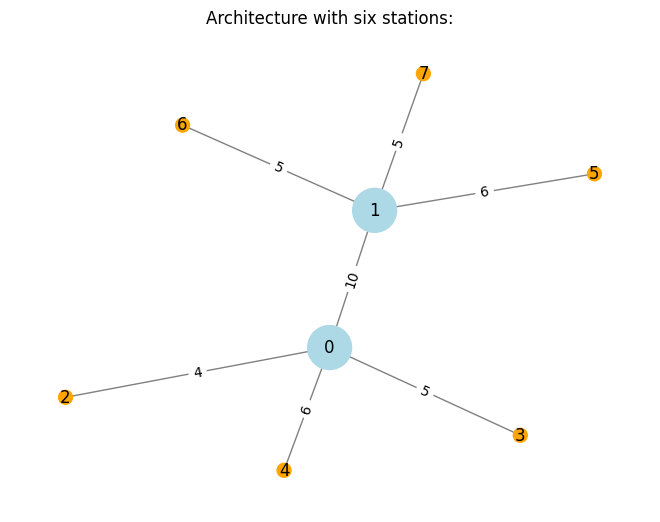

{0: [2, 3], 1: [4, 5], 2: [6, 7], 3: [0]}
[2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7]
52


In [344]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]

architecture = Architecture()
print(architecture.clusters)

for i in range(3):
    for j in executions:
        architecture.heart_beat()
        for h in j:
            architecture.generate(h)
print(architecture.data_allocation)
print(len(architecture.data_allocation))
# print(architecture.data)
# print(architecture.action_device)
# print(architecture.action_type)
# architecture.round_robin()
# print(architecture.compute_normalized_latency_dict())
# architecture.greedy_server()
# print(architecture.compute_normalized_latency_dict())

In [278]:
# 6: [2,4,4,3]
# 10: [3,6,6,5]
# 16: [4.5,9,9,8]
class AcesStepArchitectureEnv(Env):
    def __init__(self, num_stations):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.num_stations = num_stations
        self.multipliers = {
            6: [2,4,4,3],
            10: [3,6,6,5],
            16: [4.5,9,9,8]
        }

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        self.max_free_space = [self.architecture.c_capacity,self.architecture.c_capacity]

        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)
            self.max_free_space.append(self.architecture.s_capacity)

        self.last_call = [-1]
        self.weight = 0
        self.type = 0
        self.flag = False

        self.observation_space = Dict({
            "weight": Box(low=0, high=5, shape=(1,), dtype=np.float32),
            "free_space": Box(low=-10, high=50, shape=(self.num_devices,), dtype=np.float32),
            "last_calls": Box(low=-1, high=self.num_devices-1, shape=(2,), dtype=np.int32)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(2,), dtype=np.int32)

        self.reward = 0

    def get_obs(self, type):
        self.weight = self.architecture.weights[type] * self.multipliers[self.num_stations][type]
        self.flag = True if self.flag == False else False
        indices = set()
        for i in range(len(self.architecture.action_type)):
            if self.architecture.action_type[i]==type:
                indices.add(self.architecture.action_device[i])
        if len(indices) == 2:
            self.last_call = list(indices)
        elif len(indices) == 1:
            self.last_call = list(indices)
            self.last_call.append(-1)
        else:
            self.last_call = [-1,-1]
        return {
            "weight": np.array([self.weight]),
            "free_space": np.array(self.free_space),
            "last_calls": np.array(self.last_call)
        }

    def step(self,action):
        latency = 0
        alert = False
        computed_latencies = 0
        for location in action:
            for call in self.last_call:
                if call != -1:
                    latency += self.architecture.latencies[call][location]
                    computed_latencies+=1
            self.free_space[location] -= self.weight
        for i in range(len(self.free_space)):
            if self.free_space[i] <= self.max_free_space[i]*0.2:
                alert = True

        reward = -1 if alert else 1 - (latency / (computed_latencies * 22+1))

        done = False
        info = {'type': self.type}

        if self.type == 3 and self.flag == False:
            done = True
        if self.type !=3:
            if self.flag == False:
                self.type += 1

        return self.get_obs(self.type), reward, done, info

    def reset(self):
        self.architecture.heart_beat()
        for execution in self.executions[self.execution_index]:
            self.architecture.generate(execution)

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity]
        for i in range(self.num_stations):
            self.free_space.append(self.architecture.s_capacity)

        self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
        self.type = 0
        self.iter = 0
        self.flag=False
        return self.get_obs(self.type)

    def close(self):
        print('CLOSED')

In [279]:
ar = AcesStepArchitectureEnv(6)

In [280]:
ar.reset()

{'weight': array([0.025]),
 'free_space': array([50, 50,  2,  2,  2,  2,  2,  2]),
 'last_calls': array([ 2, -1])}

In [281]:
ar.action_space.sample()

array([2, 2], dtype=int32)

In [269]:
ar.step(ar.action_space.sample())

({'weight': array([1.5]),
  'free_space': array([47.   , 46.975,  1.992,  1.815,  0.416,  0.391,  1.975,  2.   ]),
  'last_calls': array([-1, -1])},
 -1,
 False,
 {'type': 3})

In [272]:
ar.step(ar.action_space.sample())
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

simulated_aces = AcesStepArchitectureEnv(6)
check_env(EnvCompatibility(simulated_aces))

In [282]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(6)), max_episode_steps=10)
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesStepArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

config["model"]["fcnet_hiddens"] =[64,64]


algorithm_unified_6 = config.build()

result_unified_6 =[]

for j in tqdm(range(100)):
    result_train = algorithm_unified_6.train()["episode_reward_mean"]
    result_unified_6.append(result_train)
    # if (j%100 == 0):
    print(result_train)
print(result_unified_6)

2023-06-22 18:24:29,571	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-22 18:24:40,321	INFO trainable.py:172 -- Trainable.setup took 13.883 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-22 18:24:40,322	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  1%|█▋                                                                                                                                                                            | 1/100 [00:11<19:16, 11.69s/it]

4.981511522543041


  2%|███▍                                                                                                                                                                          | 2/100 [00:23<19:03, 11.66s/it]

6.211859094651016


  3%|█████▏                                                                                                                                                                        | 3/100 [00:34<18:48, 11.64s/it]

6.240136229939333


  4%|██████▉                                                                                                                                                                       | 4/100 [00:46<18:48, 11.76s/it]

6.256620697776654


  5%|████████▋                                                                                                                                                                     | 5/100 [00:58<18:38, 11.77s/it]

6.157184348579819


  6%|██████████▍                                                                                                                                                                   | 6/100 [01:10<18:28, 11.79s/it]

6.289343386979374


  7%|████████████▏                                                                                                                                                                 | 7/100 [01:22<18:12, 11.75s/it]

6.283810105385457


  8%|█████████████▉                                                                                                                                                                | 8/100 [01:33<17:52, 11.65s/it]

6.152218345767291


  9%|███████████████▋                                                                                                                                                              | 9/100 [01:45<17:48, 11.74s/it]

6.328719208114918


 10%|█████████████████▎                                                                                                                                                           | 10/100 [01:57<17:29, 11.67s/it]

6.004208566377879


 11%|███████████████████                                                                                                                                                          | 11/100 [02:09<17:33, 11.84s/it]

6.036090092375618


 12%|████████████████████▊                                                                                                                                                        | 12/100 [02:21<17:22, 11.84s/it]

4.54404888293861


 13%|██████████████████████▍                                                                                                                                                      | 13/100 [02:33<17:13, 11.88s/it]

6.085999051500438


 14%|████████████████████████▏                                                                                                                                                    | 14/100 [02:44<16:57, 11.84s/it]

6.0810513081068


 15%|█████████████████████████▉                                                                                                                                                   | 15/100 [02:56<16:51, 11.90s/it]

6.04090203035679


Exception in thread Thread-796:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 16%|███████████████████████████▋                                                                                                                                                 | 16/100 [03:08<16:34, 11.84s/it]

6.020469389910813


 17%|█████████████████████████████▍                                                                                                                                               | 17/100 [03:20<16:25, 11.87s/it]

5.15295645130377


 18%|███████████████████████████████▏                                                                                                                                             | 18/100 [03:32<16:21, 11.97s/it]

5.816771316422986


 19%|████████████████████████████████▊                                                                                                                                            | 19/100 [03:44<16:01, 11.87s/it]

5.7328540660574765


 20%|██████████████████████████████████▌                                                                                                                                          | 20/100 [03:56<15:49, 11.87s/it]

5.715225009965801


 21%|████████████████████████████████████▎                                                                                                                                        | 21/100 [04:07<15:33, 11.82s/it]

6.111706051589111


 22%|██████████████████████████████████████                                                                                                                                       | 22/100 [04:19<15:17, 11.77s/it]

5.0013595604862315


 23%|███████████████████████████████████████▊                                                                                                                                     | 23/100 [04:31<15:11, 11.84s/it]

5.091512431366786


 24%|█████████████████████████████████████████▌                                                                                                                                   | 24/100 [04:43<15:04, 11.91s/it]

5.649228239729658


 25%|███████████████████████████████████████████▎                                                                                                                                 | 25/100 [04:55<14:47, 11.84s/it]

5.524256940522786


 26%|████████████████████████████████████████████▉                                                                                                                                | 26/100 [05:07<14:32, 11.79s/it]

6.094463339235095


 27%|██████████████████████████████████████████████▋                                                                                                                              | 27/100 [05:18<14:20, 11.79s/it]

5.753316335422397


 28%|████████████████████████████████████████████████▍                                                                                                                            | 28/100 [05:30<14:08, 11.79s/it]

5.9977738163574905


 29%|██████████████████████████████████████████████████▏                                                                                                                          | 29/100 [05:42<14:07, 11.94s/it]

5.610920874651942


 30%|███████████████████████████████████████████████████▉                                                                                                                         | 30/100 [05:54<13:49, 11.85s/it]

5.932047894577682


 31%|█████████████████████████████████████████████████████▋                                                                                                                       | 31/100 [06:06<13:33, 11.80s/it]

6.290106617388476


 32%|███████████████████████████████████████████████████████▎                                                                                                                     | 32/100 [06:18<13:23, 11.82s/it]

6.344785135118657


 33%|█████████████████████████████████████████████████████████                                                                                                                    | 33/100 [06:29<13:11, 11.81s/it]

6.375247057583738


 34%|██████████████████████████████████████████████████████████▊                                                                                                                  | 34/100 [06:41<12:58, 11.80s/it]

6.363124701466479


 35%|████████████████████████████████████████████████████████████▌                                                                                                                | 35/100 [06:53<12:46, 11.80s/it]

6.422693558805554


 36%|██████████████████████████████████████████████████████████████▎                                                                                                              | 36/100 [07:05<12:32, 11.76s/it]

6.443461108573163


 37%|████████████████████████████████████████████████████████████████                                                                                                             | 37/100 [07:16<12:16, 11.68s/it]

6.4695353803069535


 38%|█████████████████████████████████████████████████████████████████▋                                                                                                           | 38/100 [07:27<11:58, 11.59s/it]

6.488004643803361


 39%|███████████████████████████████████████████████████████████████████▍                                                                                                         | 39/100 [07:39<11:48, 11.61s/it]

6.4221690401763825


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 40/100 [07:51<11:35, 11.58s/it]

6.491995078726915


 41%|██████████████████████████████████████████████████████████████████████▉                                                                                                      | 41/100 [08:02<11:21, 11.56s/it]

6.437816913100784


 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                    | 42/100 [08:14<11:08, 11.53s/it]

6.533945747594475


 43%|██████████████████████████████████████████████████████████████████████████▍                                                                                                  | 43/100 [08:25<10:59, 11.57s/it]

6.531682359538128


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                 | 44/100 [08:37<10:48, 11.59s/it]

5.944644907079363


 45%|█████████████████████████████████████████████████████████████████████████████▊                                                                                               | 45/100 [08:49<10:38, 11.60s/it]

6.365629501176252


 46%|███████████████████████████████████████████████████████████████████████████████▌                                                                                             | 46/100 [09:01<10:33, 11.73s/it]

6.448971703958489


 47%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 47/100 [09:13<10:26, 11.82s/it]

6.52407170945143


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 48/100 [09:25<10:17, 11.87s/it]

6.52812950736206


 49%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 49/100 [09:36<10:00, 11.78s/it]

6.5469624647243885


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 50/100 [09:48<09:47, 11.76s/it]

6.542933326119067


 50%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 50/100 [09:49<09:49, 11.79s/it]


KeyboardInterrupt: 

In [385]:
norm_training = [x/2 for x in result_unified_6]

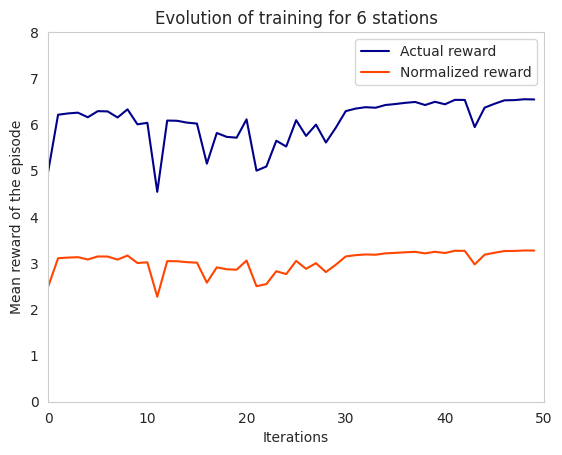

In [388]:
plt.plot(result_unified_6, color='darkblue', label='Actual reward')
plt.plot(norm_training, color='orangered', label='Normalized reward')
plt.title("Evolution of training for 6 stations")
plt.xlabel("Iterations")
plt.ylabel("Mean reward of the episode")
plt.ylim(0, 8)
plt.xlim(0, 50)
plt.legend()
plt.grid(False)

In [353]:
test_architecture = AcesStepArchitectureEnv(6)
latency_round_robin = []
latency_best_device = []
latency_algorithm = []
free_spaces = []
rewards = []

In [354]:
for i in range(100):
    obs = test_architecture.reset()
    test_architecture.architecture.round_robin()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_round_robin.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_server()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_best_device.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_algorithm()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    # print(test_architecture.architecture.compute_total_latency())
    iteration = {}
    allocation = []
    types = []
    reward = 0

    for i in range(20):
        action = algorithm_unified_6.compute_single_action(obs)
        output = test_architecture.step(action)
        obs = output[0]
        # print(obs['free_space'])
        reward += output[1]
        type = output[3]['type']
        iteration[i] = output[1]
        if type==0:
            for j in range(2):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(0)
        elif type==1:
            for j in range(4):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(1)
        elif type==2:
            for j in range(4):
                for k in range(2):
                    allocation.append(action[k])
                    types.append(2)
        else:
            for j in range(3):
                for k in range(2):
                    if output[1] != -1:
                        allocation.append(action[k])
                        types.append(3)
                    else:
                        allocation.append(random.randint(0,1))
                        types.append(3)
        if output[2]:
            break

    test_architecture.architecture.false_data_allocation = allocation
    test_architecture.architecture.false_data_types = types
    test_architecture.architecture.false_construct_dictionaries()
    # print(iteration)
    latency_algorithm.append(test_architecture.architecture.false_compute_total_latency())
    free_spaces.append(test_architecture.architecture.false_free_space())
    rewards.append(reward)

(0.0, 99.0)

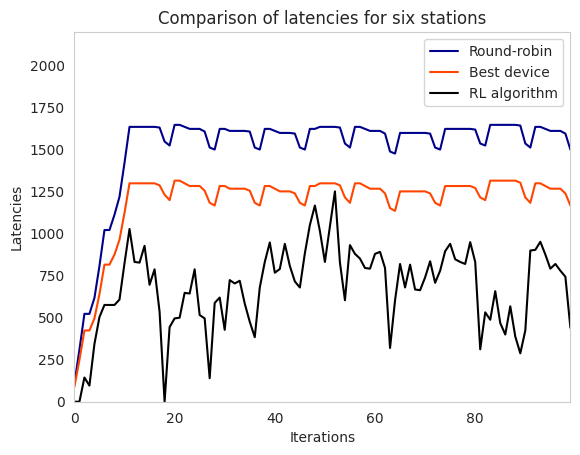

In [381]:
plt.plot(latency_round_robin, color='darkblue', label = "Round-robin")
plt.plot(latency_best_device, color='orangered', label = "Best device")
plt.plot(latency_algorithm, color='black', label = "RL algorithm")
plt.title("Comparison of latencies for six stations")
plt.xlabel("Iterations")
plt.ylabel("Latencies")
plt.legend()
plt.grid(False)
plt.ylim(0, 2200)
plt.xlim(0, 99)

In [360]:
free_space_check = []

for fs_ind in range(len(free_spaces)):
    a=0
    for key in free_spaces[fs_ind].keys():
        if free_spaces[fs_ind][key] <= 0.2:
            a=rewards[fs_ind]
    free_space_check.append(a)

In [367]:
norm_rewards = [x/2 for x in rewards]

(0.0, 99.0)

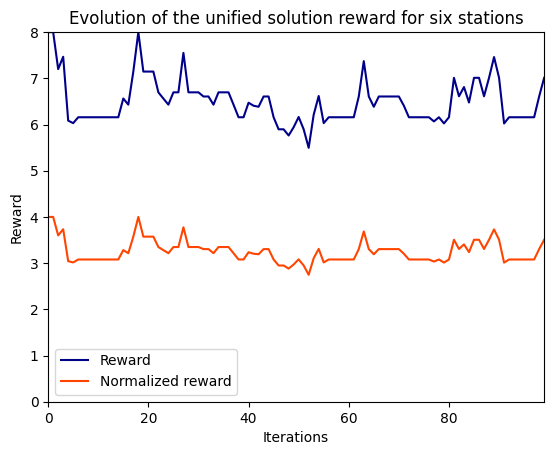

In [378]:
line=plt.plot(rewards, color='darkblue', label = "Reward")
line=plt.plot(norm_rewards, color='orangered', label = "Normalized reward")
plt.title("Evolution of the unified solution reward for six stations")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend()
plt.ylim(0.0, 8)
plt.xlim(0, 99)

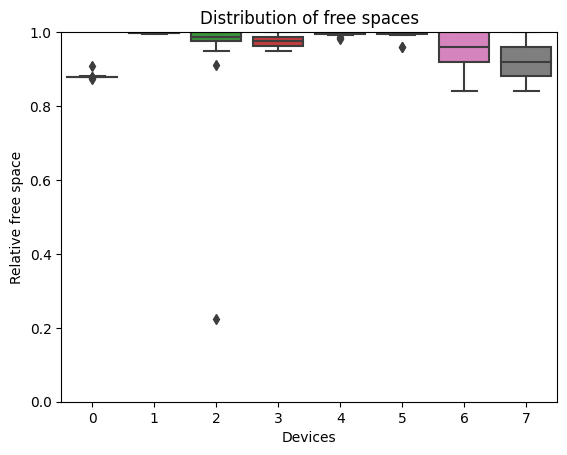

In [376]:
pre_dataframe = {}
for i in range(8):
    pre_dataframe[i] = []
for fs in free_spaces:
    for key in fs.keys():
        pre_dataframe[key].append(fs[key])
df = pd.DataFrame.from_dict(pre_dataframe)

ax = sns.boxplot(data=df).set(
    title="Distribution of free spaces",
    xlabel="Devices",
    ylabel="Relative free space",
    ylim=(0,1.0)
)